# OFDM em comunicações ópticas

Este código apresenta uma implementação de um sistema de comunicação óptica de detecção direta com modulação OFDM e envelope constante (DDO-CE-OFDM). 

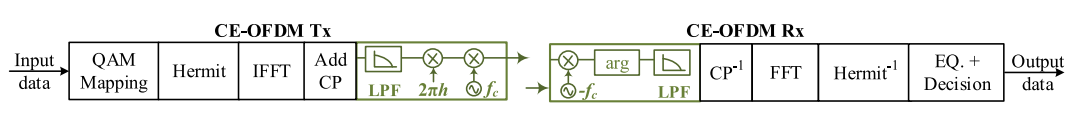

In [327]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal
from scipy.constants import c, h, e, k, pi
from scipy.fft import fft, ifft, fftshift, fftfreq
from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.metrics import signal_power, fastBERcalc
from utils.dsp import firFilter, pulseShape, lowPassFIR
from utils.models import mzm, edfa, ssfm
from commpy.utilities  import signal_power, upsample
from tqdm.notebook import tqdm

In [328]:
def modulateOFDM(N, G, symbTx, pulse):
    symbTx_P = np.zeros((int(len(symbTx)/(N/2)), N + G), complex)
    aux = 0

    for i in range(len(symbTx_P)):
        symbTx_P[i,G:G+int(N/2)] = symbTx[int(aux):int(aux+N/2)]
        aux = aux + N/2
        
        # Simetria hermitiana
        v = symbTx_P[i,G]
        symbTx_P[i,G] = v.real
        symbTx_P[i,G + int(N/2)] = v.imag 

        for j in range(int(N/2)-1):
            j = j + 1
            symbTx_P[i,G + int(N) - j] = np.conjugate(symbTx_P[i,G + j])

        # Aplicação da IFFT
        symbTx_P[i,G:N+G] = ifft(symbTx_P[i,G:N+G])*np.sqrt(N)

        # Adição do prefixo cíclico
        symbTx_P[i,:] = np.concatenate((symbTx_P[i,N:N+G],symbTx_P[i,G:N+G]))

    # Conversão Paralelo -> Serial e formatação de pulso
    symbolsUp = upsample(np.squeeze(symbTx_P.reshape(1,len(symbTx_P[0])*len(symbTx_P))), SpS)
    sigTx = firFilter(pulse, symbolsUp)
    
    return sigTx

In [329]:
def demodulateOFDM(N, G, sigRx, pulse, SpS):
    # Filtro casado
    #sigRx  = firFilter(pulse/SpS, sigRx)
    
    # Separando as amostras
    symbRx = sigRx[0::SpS]

    # Conversão Serial -> Paralelo
    symbRx_P = np.zeros((int(len(symbRx)/(N+G)), N), complex)
    aux = 0

    for i in range(len(symbRx_P)):
        symbRx_P[i,0:N] = symbRx[aux+G:aux+N+G]   # Retirando o prefixo cíclico e paralelizando a informação
        aux = aux + N + G

        # Aplicação da FFT
        symbRx_P[i,:] = fft(symbRx_P[i,:])/np.sqrt(N)
    
    # Conversão Paralelo -> Serial
    symbRx_S = np.zeros(int(len(symbRx_P[0])*len(symbRx_P)/2), complex)
    aux = 0

    # Retirada da simetria hermitiana
    for i in range(len(symbRx_P)):
        symbRx_S[int(aux):int(aux + N/2)] = symbRx_P[i,0:int(N/2)]
        aux = aux + N/2

    return symbRx_S

### 1 - Transmissão

In [330]:
# Parâmetros da simulação
SpS = 24                   # Amostras coletadas por segundo
Rs  = 1.5e9                # Taxa de símbolos
Ts  = 1/Rs                 # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)           # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa                 # Período de amostragem
Fc  = 193.4e12             # Hz  1550.2 nm

In [331]:
# Sinalização original: M-QAM
M = 4
constType = 'qam'

constSymb = GrayMapping(M, constType)
bitMap = demodulateGray(constSymb, M, constType)
bitMap = bitMap.reshape(-1, int(np.log2(M)))

# Gera sequência de bits aleatórios
bits = np.random.randint(2, size = 6*2**14)
#bits = np.random.randint(2, size = 2**10) # Do artigo

symbTx = modulateGray(bits, M, constType)
Es = signal_power(symbTx)
symbTx = symbTx / np.sqrt(Es)

In [332]:
# Paralelizando a informação em pacotes de N símbolos obedecendo uma simetria hermitiana
N = 512             # Tamanho dos blocos de informação (são N/2 sub-portadoras!)
G = int(N/128)        # Tamanho do prefixo cíclico

pulse = pulseShape('rrc', SpS)
pulse = pulse/max(abs(pulse))

sigTx = modulateOFDM(N, G, symbTx, pulse)

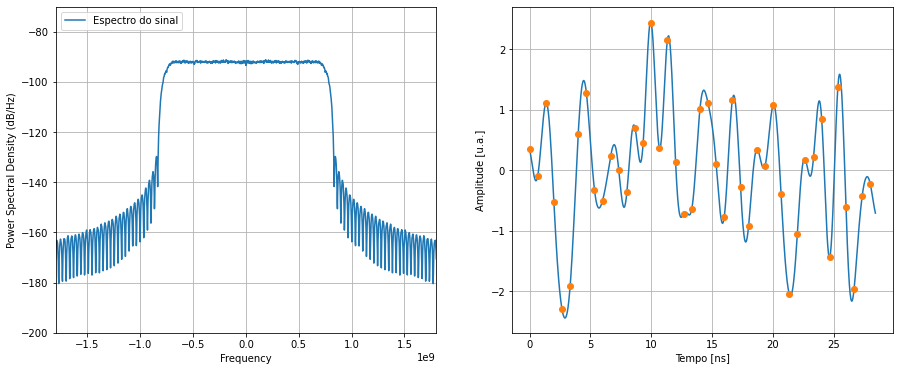

In [333]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

t = np.arange(0, sigTx.size)*Ta
idX = np.arange(0, 1024)

axs[0].set_xlim(-1.2*Rs,1.2*Rs)
axs[0].set_ylim(-200,-70)
axs[0].psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX]*1e9, sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

axs[1].plot(t[idX][0::SpS]*1e9, sigTx[idX][0::SpS].real,'o')

### 1.1 - Modulação em fase

3.010366236077897

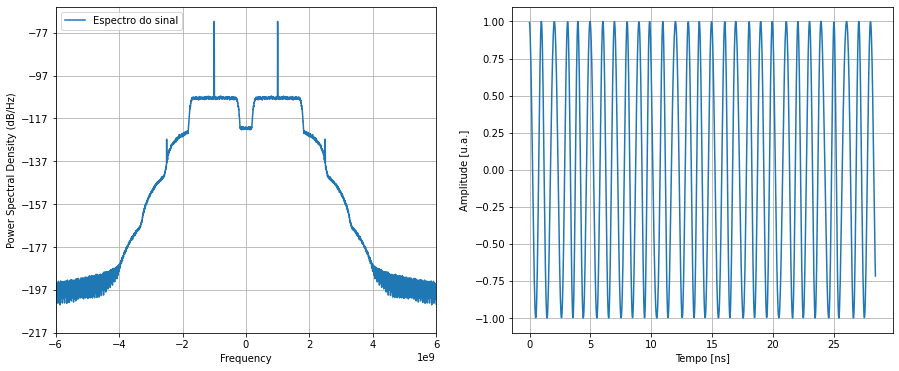

In [334]:
H  = 0.35/(2*pi)    # Índice de modulação
fc = 1e9            # Frequência da portadora
A  = 1              # Amplitude da portadora

sigTx_CE = A*np.cos(2*pi*fc*t + 2*pi*H*sigTx)

fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].set_xlim(-4*Rs, 4*Rs)
axs[0].psd(sigTx_CE,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX]*1e9, sigTx_CE[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

# PAPR
L = 1000
PP = max(sigTx_CE[0:L*(N+G)].real)**2/signal_power(sigTx_CE[0:L*(N+G)].real)

PAPR = 10*np.log10(PP)
PAPR

In [335]:
# Parâmetros da fibra
alpha = 0.2                # dB/km
alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))

D     = 18e-6             # s/(m*m) SMF
gamma = 1.3e-3            # W-1/m
Lspan = 50e3             # Comprimento do segmento de SMF
hz    = 1e3               # Passo para SSF
Nspan = 5
Ltotal = Nspan*Lspan

# Parâmetros do amplificador
amp = 'edfa'
NF  = 7

# Parâmetros do sinal
lmbd   = 1550e-9          # comprimento de onda
Pi_dBm = 5 #5#10#15       # potência de sinal óptico na entrada do modulador em dBm

# Parâmetros do MZM
Vπ = 3
Vb = -0.5*Vπ
Pi = 10**(Pi_dBm/10)*1e-3  # potência de sinal óptico em W na entrada do MZM

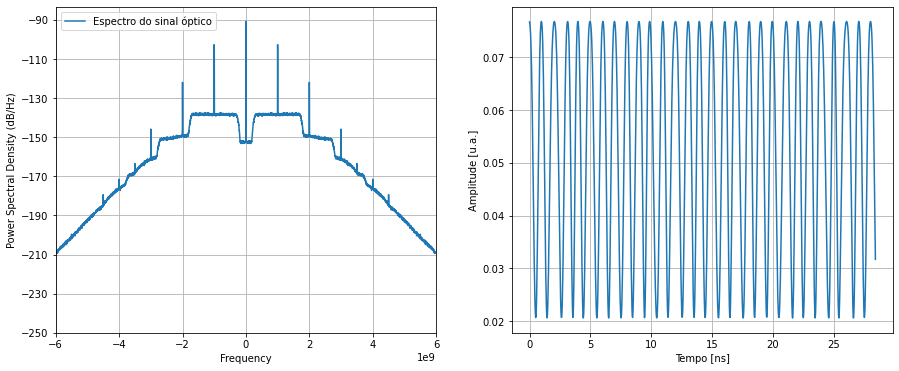

In [336]:
# Modulação óptica
Ai     = np.sqrt(2*Pi)
sigTxo = mzm(Ai, Vπ, sigTx_CE, Vb)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-4*Rs, 4*Rs)
axs[0].psd(sigTxo,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX]*1e9, sigTxo[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

### 2 - Canal: fibra óptica

In [337]:
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

# Solução da NLSE pelo método SSF
sigRxo = ssfm(sigTxo, Fa, Ltotal, Lspan, hz, alpha, gamma, D, Fc, amp, NF)

sigRxoFFT = np.fft.fftshift(np.fft.fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2

  0%|          | 0/5 [00:00<?, ?it/s]

Potência do sinal Tx (em dBm) = 5.00 dBm
Potência do sinal Rx (em dBm) = 5.00 dBm


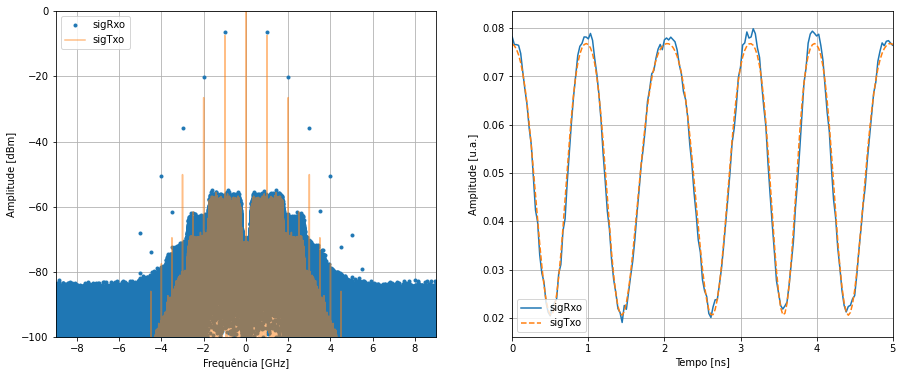

In [338]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-6e-9*Rs, 6e-9*Rs)
axs[0].set_ylim(-100, 0)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

axs[1].plot(t[idX]*1e9, np.abs(sigRxo)[idX], label = 'sigRxo')
axs[1].plot(t[idX]*1e9, np.abs(sigTxo)[idX], '--', label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_xlim(0, 5)
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

print('Potência do sinal Tx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))
print('Potência do sinal Rx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigRxoPx)/1e-3)))

### 2 - Recepção

In [339]:
# Parâmetros do receptor
Tc  = 25        # temperatura em Celsius
Rd  = 0.85      # responsividade em A/W
Id  = 5e-9      # corrente de escuro em nA
RL  = 50        # RL em Ohms
B   = 5e9       # banda do receptor em Hz

In [340]:
Pin = (np.abs(sigRxo)**2).mean()      # Potência óptica média recebida

# Fotocorrente livre de ruído do receptor
Ip = Rd*np.abs(sigRxo)**2

# Ruído de disparo 
σ2_s = 2*e*(Rd*Pin + Id)*B            # Variância do ruído de disparo 

# Ruído térmico
T = Tc + 273.15                       # Temperatura em Kelvin
σ2_T = 4*k*T*B/RL                     # Variância do ruído térmico

# Adiciona ruído do receptor p-i-n aos sinais
Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

I = Ip + Is + It

# Filtragem
I_Rx = firFilter(lowPassFIR(B, Fa, 8000, 'rect'), I)  # Dúvida!

### 2.1 - Extração da fase

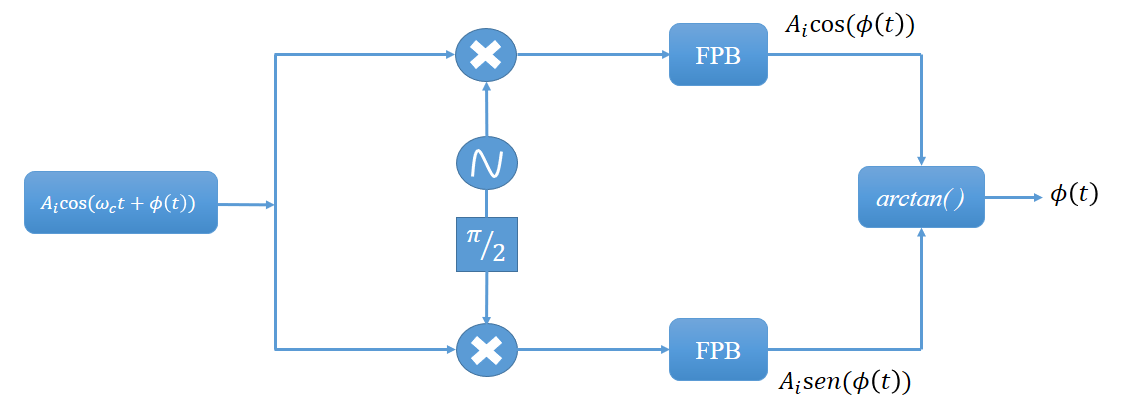

In [341]:
"""Ix = I*np.cos(2*pi*fc*t)

NFFT = len(Ix)
Ix_FFT = np.fft.fftshift(np.fft.fft(Ix))/NFFT
Ix_Px  = np.abs(Ix_FFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(Ix_FFT), Ta))

plt.figure(figsize = (8,6))
plt.plot(1e-9*freq, 10*np.log10(1e3*Ix_Px))
plt.xlim(-10, 10)
plt.ylim(-120,-60)
plt.grid()"""
print("Trecho de código útil para conferir o espectro do sinal da corrente após a demodulação")

Trecho de código útil para conferir o espectro do sinal da corrente após a demodulação


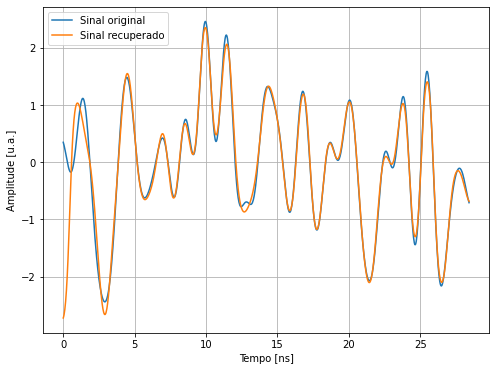

In [342]:
# Extração da fase
I1 = firFilter(pulse/SpS, I*np.sin(2*pi*fc*t))
I2 = firFilter(pulse/SpS, I*np.cos(2*pi*fc*t))

#I1 = firFilter(lowPassFIR(Rs/2, Fa, 8000, 'rect'), I*np.sin(2*pi*fc*t))
#I2 = firFilter(lowPassFIR(Rs/2, Fa, 8000, 'rect'), I*np.cos(2*pi*fc*t))

Φ = -np.unwrap(np.arctan(I1/I2))/(2*pi*H)

plt.figure(figsize = (8,6))
plt.plot(t[idX]*1e9, sigTx[idX].real, label = 'Sinal original')
plt.plot(t[idX]*1e9, Φ[idX], label = 'Sinal recuperado')
plt.legend(loc = 'upper left')
plt.xlabel('Tempo [ns]')
plt.ylabel('Amplitude [u.a.]')
plt.grid()

### 2.2 - Demodulação dos símbolos

In [343]:
symbRx = demodulateOFDM(N, G, Φ/0.2, pulse, SpS)

symbRx[0::int(N/2)] = 'nan'
symbTx[0::int(N/2)] = 'nan'

symbTx = symbTx[~np.isnan(symbTx)]
symbRx = symbRx[~np.isnan(symbRx)]
      
Es = signal_power(symbTx)
Er = signal_power(symbRx)
    
# Cálculo da BER
fastBERcalc(symbRx/np.sqrt(Er), symbTx/np.sqrt(Es), M, 'qam')

(array([0.]), array([0.]), array([25.68661041]))

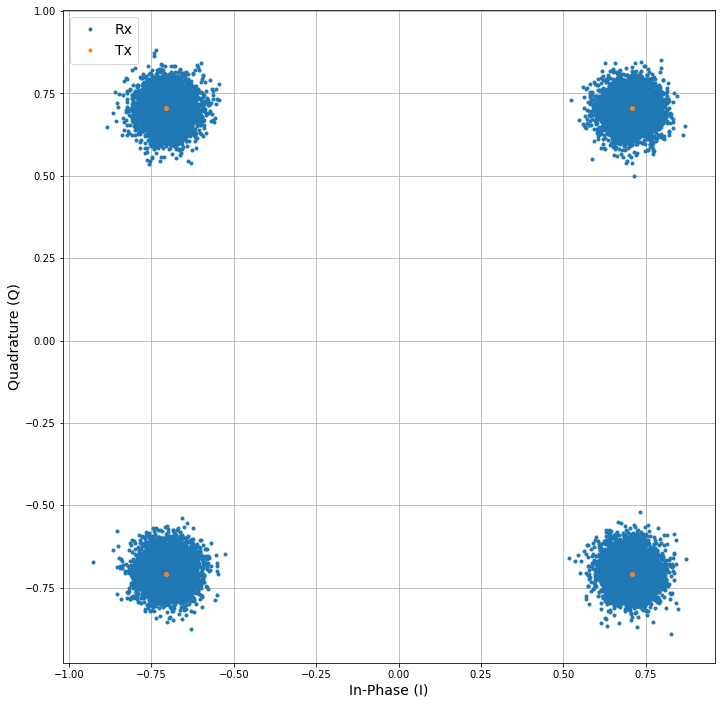

In [344]:
plt.figure(figsize=(12,12))
plt.plot(-symbRx.real/np.sqrt(Er), -symbRx.imag/np.sqrt(Er),'.', label='Rx')
plt.plot(symbTx.real, symbTx.imag,'.', label='Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)', fontsize = 14)
plt.ylabel('Quadrature (Q)', fontsize = 14)
plt.legend(fontsize = 14);
plt.grid()